In [3]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

1 GPUs


In [4]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
layer_name = 'block5_conv3' # The target layer that is the last layer of VGG16.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

In [8]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

In [4]:
filter_number = 3
def loss(output):
    return output[..., filter_number]

In [13]:
%%time
from tf_keras_vis.utils.callbacks import Print

# Generate max activation
activation = activation_maximization(loss,
                                     callbacks=[Print(interval=50)])
image = activation[0].astype(np.uint8)

# Render
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
plt.tight_layout()
plt.show()

InvalidArgumentError: slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [10]:
filter_numbers = [63, 132, 320]

# Define loss function that returns multiple filter outputs.
def loss(output):
    return (output[0, ..., 63], output[1, ..., 132], output[2, ..., 320])

In [11]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

Steps: 050	Losses: [[575.8225708007812, 374.69921875, 552.4085083007812]],	Regularizations: [('TotalVariation', 44.336517333984375), ('L2Norm', 0.014687778428196907)]
Steps: 100	Losses: [[678.6720581054688, 512.3482055664062, 695.8201293945312]],	Regularizations: [('TotalVariation', 48.85078430175781), ('L2Norm', 0.014552661217749119)]
Steps: 150	Losses: [[889.4212646484375, 651.187255859375, 835.2544555664062]],	Regularizations: [('TotalVariation', 56.00276565551758), ('L2Norm', 0.014453562907874584)]
Steps: 200	Losses: [[932.71826171875, 619.1980590820312, 963.9059448242188]],	Regularizations: [('TotalVariation', 53.9470329284668), ('L2Norm', 0.014380954205989838)]


FileNotFoundError: [Errno 2] No such file or directory: 'images/visualize-filters.png'

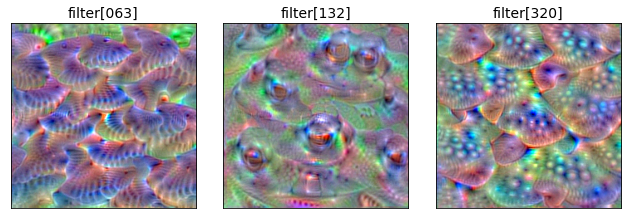

In [12]:
%%time

# Generate max activation
activations = activation_maximization(loss,
                                      seed_input=seed_input, # To generate multiple images
                                      callbacks=[Print(interval=50)])
images = [activation.astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.savefig('images/visualize-filters')
plt.show()